In [1]:
#imports
import nest
import yaml
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
from analysis_functions import *
from asserting_functions import *
from nest_reset_create_connect_simulate import *
from yaml_io import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Nov  6 2022 20:22:08

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
is_standard_nest=True
is_verbose=False
debug_mode = True
high_noise = True
nest_pms={}

#total sim, resolution and recording times
times = read_sim_and_recording_times_yaml(is_verbose)

#read general network parameters
config = read_general_config_yaml(is_verbose)

# Extract config subsets of params 
brain_state = config['brain_state']
network = config['network']
weights = config['weights']
poisson = config['poisson']
dc_exc = config['dc_exc']
dc_inh = config['dc_inh']

In [3]:
#reading neural parameters
exc_pms,inh_pms = read_neural_parameters(is_standard_nest,is_verbose)

nest_pms["exc_pms"]=inh_pms
nest_pms["exc_pms"]=exc_pms
exc_t_ref_ms=0.0

In [4]:
num_exc_pop=network['num_exc_pop']
num_exc_neu_per_pop=network['num_exc_neu_per_pop']
# Calculate number of inhibitory neurons based on excitatory populations and neurons per pop
network['num_inh_neu'] = int(network['num_exc_pop'] * network['num_exc_neu_per_pop'] / 4)
num_inh_neu = network['num_inh_neu']

#setting a minimum sinaptic delay if exc_t_ref_ms<=2.0
min_syn_delay_ms = 3.0 if exc_t_ref_ms else 0.0

In [5]:
use_recurrency = network["use_exc_recurrency"]
if use_recurrency:
    if brain_state == "awake":
        weights=weights['awake']
    else:
        weights=weights['NREM']                   
    recurrent_weight = weights['recurrent_weight'] if use_recurrency else 0.0
    inh_to_exc_weight = weights["inh_to_exc_weight"]
    exc_to_inh_weight = weights["exc_to_inh_weight"]
    inh_to_inh_weight = weights["inh_to_inh_weight"]  

In [6]:
use_poisson_generators = network["use_poisson_generators"]
if use_poisson_generators:
    num_poisson_generators=network["num_poisson_generators"]
    # Set stimulation parameters based on brain state
    if brain_state == "awake":
        poisson=poisson['awake']
    else:
        if brain_state == "NREM":
            poisson=poisson['NREM']
        else:
            assert(false==true)
    poisson_spreading_factor=poisson['poisson_noise_spreading_factor']
    poisson_rate = poisson['poisson_basic_rate']/ poisson_spreading_factor
    poisson_weight = poisson['poisson_weight'] * poisson_spreading_factor
    poisson_delta = poisson["poisson_delta"]

# Create rate arrays for Poisson generators
#poisson_rate_arrays = [poisson_rate + i * poisson_delta for i in range(network["num_exc_neu_per_pop"])]
#print("number of poisson generators",len(poisson_rate_arrays))

In [7]:
#dc inhjectors to excitatory neurons
use_dc_exc_injectors = network["use_dc_exc_injectors"]
if use_dc_exc_injectors: 
    dc_exc_amplitudes = dc["amplitudes"]
    dc_exc_weight = dc["weight"]
    dc_exc_delay = dc["delay"]
    dc_exc_start = 0.0
    dc_exc_stop = times["sim_pms"]["stop_ms"]

#dc inhjectors to inhibitory neurons
use_dc_inh_injector = network["use_dc_inh_injector"]  # DC injection for inhibitory neurons
if use_dc_inh_injector:
    dc_inh_amplitude = dc_inh["amplitude"] # DC amplitude for inhibitory neurons
    dc_inh_weight = dc_inh["weight"]
    dc_inh_delay = dc_inh["delay"]
    dc_inh_start = 0.0
    dc_inh_stop = times["sim_pms"]["stop_ms"]

In [8]:
exc_neu_params={
            "a": exc_pms['a'],
            "b": exc_pms['b_awake'] if brain_state == "awake" else exc_pms['b_sleep'],
            "t_ref": exc_pms['t_ref'],
            "Delta_T": exc_pms['Delta_T'],
            "C_m": exc_pms['C_m'],
            "g_L": exc_pms['g_L'],
            "E_L": exc_pms['E_L_awake'] if brain_state == "awake" else exc_pms['E_L_sleep'],
            "V_reset": exc_pms['V_reset_awake'] if brain_state == "awake" else exc_pms['V_reset_sleep'],
            "tau_w": exc_pms['tau_w'],
            "V_th": exc_pms['V_th'],
            "V_peak": exc_pms['V_peak'],
        }


inh_neu_params={
        "a": inh_pms['a'],
        "b": inh_pms['b'],
        "t_ref": inh_pms['t_ref'],
        "Delta_T": inh_pms['Delta_T'],
        "C_m": inh_pms['C_m'],
        "g_L": inh_pms['g_L'],
        "E_L": inh_pms['E_L'],
        "V_reset": inh_pms['V_reset'],
        "tau_w": inh_pms['tau_w'],
        "V_th": inh_pms['V_th'],
        "V_peak": inh_pms['V_peak'],
    }

In [9]:
nest_pms={}
nest_pms["sim_pms"]=times["sim_pms"]
nest_pms["use_standard_exc_nest_neuron"]=True
nest_pms["exc_neu_params"]=exc_neu_params
nest_pms["inh_neu_params"]=inh_neu_params
nest_pms["exc_t_ref_ms"]=exc_t_ref_ms
nest_pms["recording_pms"]=times["recording_pms"]

#how many neurons
nest_pms["network"]={}
nest_pms["network"]["num_exc_neu_per_pop"]=num_exc_neu_per_pop
nest_pms["network"]["num_exc_pop"]=num_exc_pop
nest_pms["network"]["num_inh_neu"]=num_inh_neu

#synaptic weights
nest_pms["network"]["use_exc_recurrency"]=use_recurrency
nest_pms["network"]["weights"]={}
nest_pms["network"]["weights"]["exc_to_exc"] = recurrent_weight 
nest_pms["network"]["weights"]["inh_to_exc_weight"] = inh_to_exc_weight
nest_pms["network"]["weights"]["exc_to_inh_weight"] = exc_to_inh_weight
nest_pms["network"]["weights"]["inh_to_inh_weight"] = inh_to_inh_weight
nest_pms["network"]["min_syn_delay_ms"]=min_syn_delay_ms
#poisson generators
nest_pms["network"]["use_poisson_generators"]=use_poisson_generators
if(use_poisson_generators):
    nest_pms["network"]["num_poisson_generators"]=num_poisson_generators
    nest_pms["poisson"]={}
    nest_pms["poisson"]["poisson_noise_spreading_factor"]=poisson_spreading_factor
    nest_pms["poisson"]["poisson_rate"]=poisson_rate
    nest_pms["poisson"]["poisson_weight"]=poisson_weight
    nest_pms["poisson"]["poisson_delta"]=poisson_delta

#DC exc injectors
nest_pms["use_dc_exc_injectors"] = use_dc_exc_injectors
if(use_dc_exc_injectors):
    nest_pms["dc_exc"]={}
    nest_pms["dc_exc"]["start_ms"] = dc_exc_start
    nest_pms["dc_exc"]["stop_ms"] = dc_exc_stop
    nest_pms["dc_exc"]["dc_exc_amplitudes"] = dc_exc_amplitudes
    nest_pms["dc_exc"]["dc_exc_weight"] = dc_exc_weight
    nest_pms["dc_exc"]["dc_exc_delay_ms"] = dc_exc_delay

#DC inh injectors
nest_pms["use_dc_inh_injector"] = use_dc_inh_injector
if use_dc_inh_injector:
    nest_pms["dc_inh"]={}
    nest_pms["dc_inh"]["start_ms"]=dc_inh_start 
    nest_pms["dc_inh"]["stop_ms"]=dc_inh_stop 
    nest_pms["dc_inh"]["dc_inh_amplitude"] = dc_inh_amplitude
    nest_pms["dc_inh"]["weight"]=dc_inh_weight
    nest_pms["dc_inh"]["delay_ms"]=dc_inh_delay 

In [10]:
print("nest_pms",nest_pms)

nest_pms {'sim_pms': {'stop_ms': 25000.0, 'resolution_ms': 0.1}, 'use_standard_exc_nest_neuron': True, 'exc_neu_params': {'a': 0, 'b': 200.0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 200.0, 'g_L': 10.0, 'E_L': -68.0, 'V_reset': -65.0, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0}, 'inh_neu_params': {'a': 0, 'b': 0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 50.0, 'g_L': 5.0, 'E_L': -63.0, 'V_reset': -65.0, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0}, 'exc_t_ref_ms': 0.0, 'recording_pms': {'start_ms': 5000.0, 'stop_ms': 25000.0, 'duration_ms': 20000.0}, 'network': {'num_exc_neu_per_pop': 20, 'num_exc_pop': 4, 'num_inh_neu': 20, 'use_exc_recurrency': True, 'weights': {'exc_to_exc': 19.0, 'inh_to_exc_weight': -1.7, 'exc_to_inh_weight': 7.0, 'inh_to_inh_weight': -1.0}, 'min_syn_delay_ms': 0.0, 'use_poisson_generators': True, 'num_poisson_generators': 20}, 'poisson': {'poisson_noise_spreading_factor': 4.0, 'poisson_rate': 150.0, 'poisson_weight': 2.4, 'poisson_delta': 0.0}, 'use_dc_exc_injector

In [11]:
sim_completed, spike_recorders, inh_spike_recorder = nest_reset_create_connect_simulate(nest_pms)
print("sim_completed", sim_completed)


sim_completed True
Apr 30 23:02:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Apr 30 23:02:44 NodeManager::prepare_nodes [Info]: 
    Preparing 126 nodes for simulation.

Apr 30 23:02:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 126
    Simulation time (ms): 25000
    Number of OpenMP threads: 1
    Not using MPI

Apr 30 23:03:32 SimulationManager::run [Info]: 
    Simulation finished.


In [12]:
d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]

In [13]:
#before analysis, preliminary sim look 
preliminary_sim_look(debug_mode,nest_pms, spike_recorders, inh_spike_recorder, nest_pms["recording_pms"])   

pop 0 first recorded event at time 5006.2 from sender 6
pop 0 last recorded event at time 24141.4 from sender 18
pop 0 total_exc_pop_spikes= 1148
pop 0 average_exc_pop_firing_rate_Hz= 2.87 Hz
pop 1 first recorded event at time 5311.3 from sender 35
pop 1 last recorded event at time 24841.3 from sender 39
pop 1 total_exc_pop_spikes= 1173
pop 1 average_exc_pop_firing_rate_Hz= 2.9325 Hz
pop 2 first recorded event at time 5436.6 from sender 42
pop 2 last recorded event at time 24495.8 from sender 60
pop 2 total_exc_pop_spikes= 1158
pop 2 average_exc_pop_firing_rate_Hz= 2.895 Hz
pop 3 first recorded event at time 6219.2 from sender 67
pop 3 last recorded event at time 24619.8 from sender 80
pop 3 total_exc_pop_spikes= 1071
pop 3 average_exc_pop_firing_rate_Hz= 2.6775 Hz
INHIBITORIES 3 first recorded event at time 5011.1 from sender 81
INHIBITORIES 3 last recorded event at time 24840.600000000002 from sender 100
INHIBITORIES 3 total_inh_pop_spikes= 7000
INHIBITORIES 3 average_inh_firing_rate

In [14]:
#setting the analysis parameters
default_analysis=True

if default_analysis:
    crop_start_ms=nest_pms["recording_pms"]["start_ms"] 
    crop_stop_ms=nest_pms["recording_pms"]["stop_ms"] 
else:
    crop_start_ms = 000.0 + nest_pms["recording_pms"]["start_ms"]
    crop_stop_ms= 200.0 + nest_pms["recording_pms"]["start_ms"]

crop_pms={"start_ms":crop_start_ms, 
          "stop_ms":crop_stop_ms}
crop_pms["duration_ms"]=crop_pms["stop_ms"]-crop_pms["start_ms"]

spectrogram_window_ms=crop_pms["duration_ms"]/4
    
sampling_pms={"spikes_sampling_window_ms": 0.2,
              "spectrogram_window_ms":spectrogram_window_ms,
              "low_freq_sampling_window_ms":12.5}

analysis_pms={}                                 
analysis_pms.update(derive_analysis_pms_from_sampling_pms(sampling_pms))
  
#assertions on crop, recording and spectrogram params
check_analysis_pms(crop_pms,nest_pms["recording_pms"],analysis_pms)

# Assuming spike_recorders is a list of spike recorder IDs previously created in your NEST simulation
cropped_events = crop_events_from_spike_recorders(crop_pms, spike_recorders)
"""
print("type of cropped_events",type(cropped_events), len(cropped_events))
print(cropped_events)
"""
cropped_inh_events = crop_inh_events(crop_pms, inh_spike_recorder)
"""
print("type of cropped_inh_events",type(cropped_inh_events), len(cropped_inh_events))
print(cropped_inh_events)
"""
#print the set of analysis parameters
analysis_pms_print(nest_pms["recording_pms"],crop_pms,analysis_pms)

---RECORDING INTERVAL---
start recording at time 5000.0 ms
stop recording at time 25000.0 ms
recording_duration 20000.0 ms
---CROPPING INTERVAL
crop start at time 5000.0 ms
crop stop at time 25000.0 ms
crop duration 20000.0 ms
---HIGH FREQ analysis AND (spikes) 
spectogram window 5000.0 ms
lower_detectable_frequency 0.2 Hz
spikes sampling window 0.2 ms
analysis sampling freq 5000.0 Hz
max nyquist frequency 2500.0 Hz
----LOW FREQ analysis (ECG, LFP like)
(low freq) spectrogram window 5000.0 ms
lower_detectable_frequency 0.2 Hz
low freq sampling window 12.5 ms
low freq sampling freq 80.0 Hz
(low_freq) max nyquist frequency 40.0 Hz
(low freq) spectrogram window 5000.0 ms


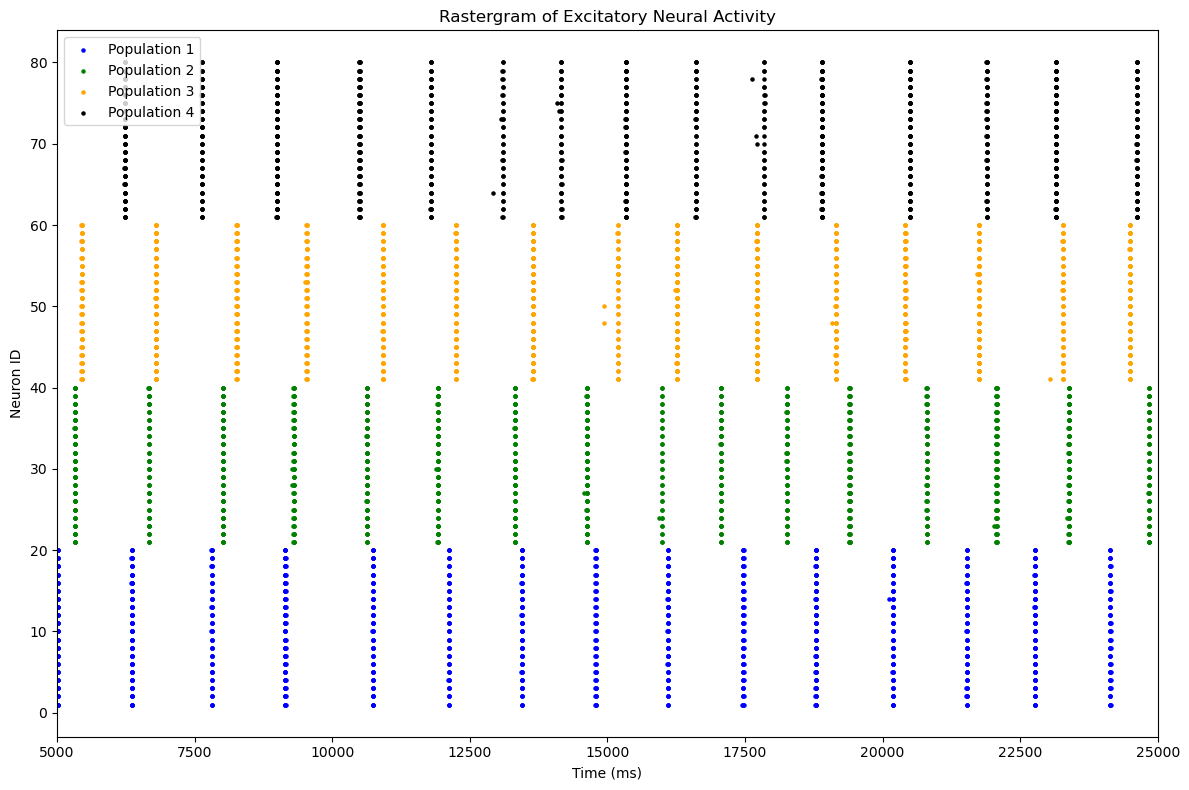

In [15]:
#plot of the rastegram of excitatory neurons
exc_pops_rastegram_plot(cropped_events, num_exc_pop, crop_pms)

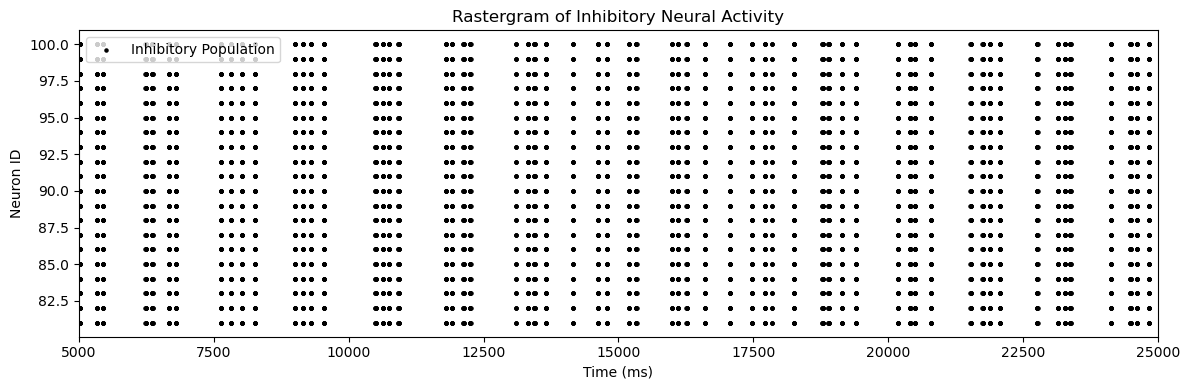

In [16]:
#plot of the rastegram of inhibitory neurons
inh_rastergram_plot(cropped_inh_events, crop_pms)

sampling_rate_Hz 5000.0
duration_ms 4.0
std_dev_ms 0.5
len of kernel 20


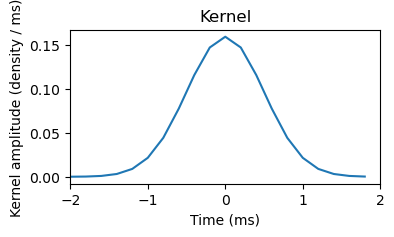

In [17]:
#preparing to smooth the single spike with the form of a spike event
sampling_rate_Hz = analysis_pms["analysis_sampling_freq_Hz"] #Hz sampling rate
print("sampling_rate_Hz", sampling_rate_Hz)
duration_ms = 4.0 # Duration of smoothing effect ms
print("duration_ms", duration_ms)
std_dev_ms = 0.5  # Standard deviation in ms
print("std_dev_ms", std_dev_ms)

single_spike_kernel = gaussian_kernel(duration_ms, sampling_rate_Hz, std_dev_ms)
print("len of kernel",len(single_spike_kernel))

kernel_plot(single_spike_kernel, sampling_rate_Hz)

In [18]:
#collect spike spikes from all populations in a single vector 
single_trace_spike_times = combine_spike_times_in_single_trace(cropped_events, num_exc_pop)

In [19]:
#Calculate combined firing rates
time_points, combined_firing_rate = \
    calculate_firing_rate(crop_pms, analysis_pms, single_trace_spike_times, num_exc_pop*num_exc_neu_per_pop)

In [20]:
instantaneous_firing_rate_plot=False
if instantaneous_firing_rate_plot:
    #plot of combined instantaneous firing rates   
    firing_rates_plot(time_points, combined_firing_rate, crop_pms) 

len of smoothed signal 99999
type of smoothed signal <class 'numpy.ndarray'>


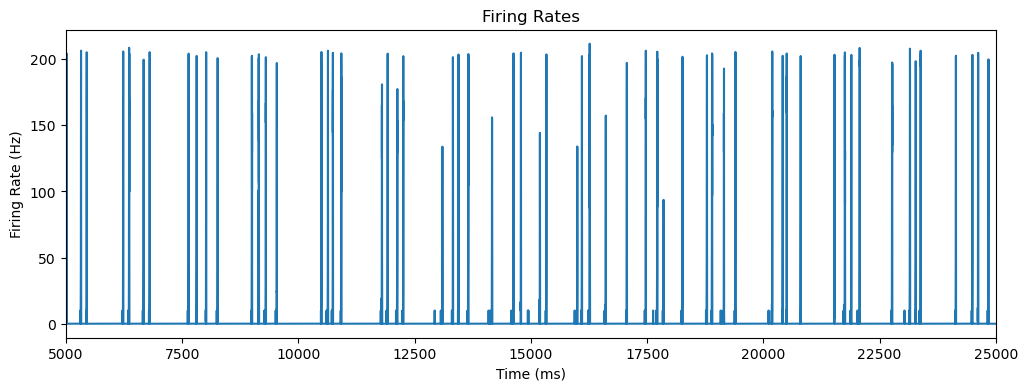

In [21]:
smoothed_spikes_firing_rate = smooth_signal(combined_firing_rate, single_spike_kernel)
print("len of smoothed signal", len(smoothed_spikes_firing_rate))
print("type of smoothed signal", type(smoothed_spikes_firing_rate))
firing_rates_plot(time_points, smoothed_spikes_firing_rate, crop_pms) 

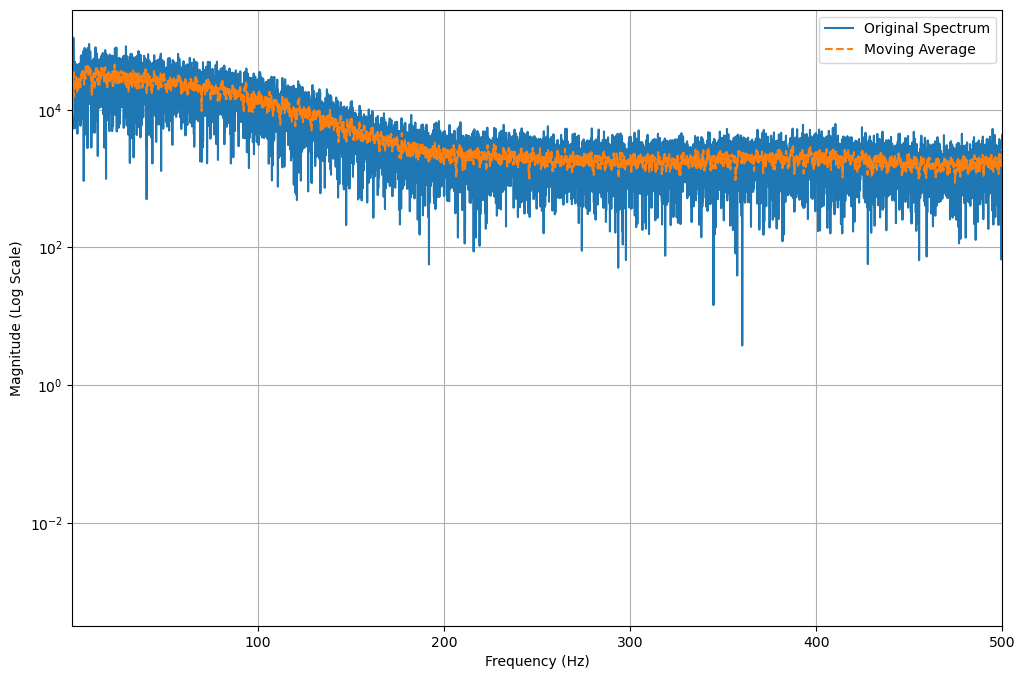

max of fft at 0.7000070000700007


In [22]:
full_spectrum_preview=True

lower_detectable_freq_Hz=analysis_pms["lower_detectable_frequency_Hz"]
max_analysis_freq_Hz=analysis_pms["max_nyquist_Hz"]
max_freq_plot_Hz = 500
assert(max_freq_plot_Hz <= max_analysis_freq_Hz)

if full_spectrum_preview:
    averaging_freq_window_size_Hz = 10 #Hz

    compute_and_plot_spectrum_with_moving_average(smoothed_spikes_firing_rate,\
        analysis_pms, averaging_freq_window_size_Hz, max_freq_plot_Hz)
    #compute_and_plot_spectrum_with_moving_average(combined_firing_rate, sampling_rate_Hz, averaging_freq_window_size_Hz, max_freq_plot_Hz)


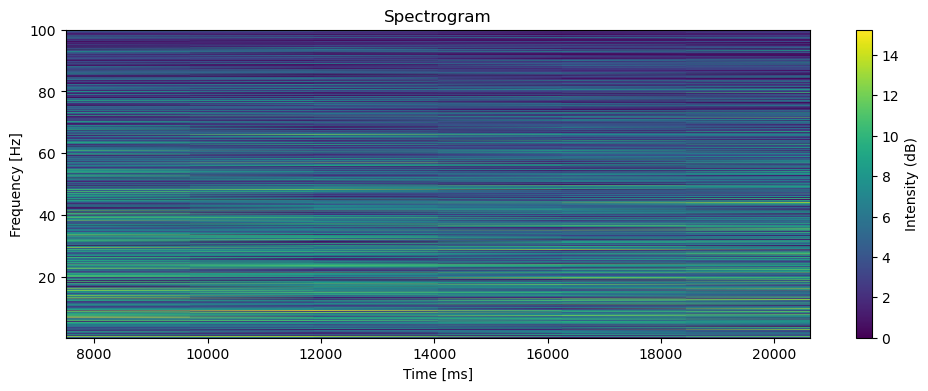

In [23]:
max_plot_freq_Hz=100

#Spectrogram plot
plot_spectrogram(time_points[0],\
                 smoothed_spikes_firing_rate,\
                 analysis_pms, max_plot_freq_Hz)

#Spectrogram plot
#plot_spectrogram(time_points[0], combined_firing_rate, analysis_pms)

sampling_rate_Hz 5000.0
duration_ms 100.0
std_dev_ms 12.0
len of kernel 500


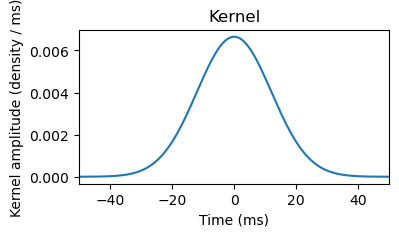

In [24]:
#smoothing the spike gaussians with synaptic times for ECG/LFP/ECoG like analysis
sampling_rate_Hz = analysis_pms["analysis_sampling_freq_Hz"] #Hz sampling rate
print("sampling_rate_Hz", sampling_rate_Hz)
duration_ms = 100.0 # Duration of smoothing effect ms
assert(crop_pms["duration_ms"]>=duration_ms)
print("duration_ms", duration_ms)
std_dev_ms = 12.0  # Standard deviation in ms
print("std_dev_ms", std_dev_ms)
tissue_response_kernel = gaussian_kernel(duration_ms, sampling_rate_Hz, std_dev_ms)
print("len of kernel",len(tissue_response_kernel))

kernel_plot(tissue_response_kernel, sampling_rate_Hz)

In [25]:
#smoothed_spikes_firing_rate = smooth_signal(combined_firing_rate, single_spike_kernel)
tissue_response_rate = smooth_signal(smoothed_spikes_firing_rate, tissue_response_kernel)

len of tissue signal 99999
type of tissue signal <class 'numpy.ndarray'>


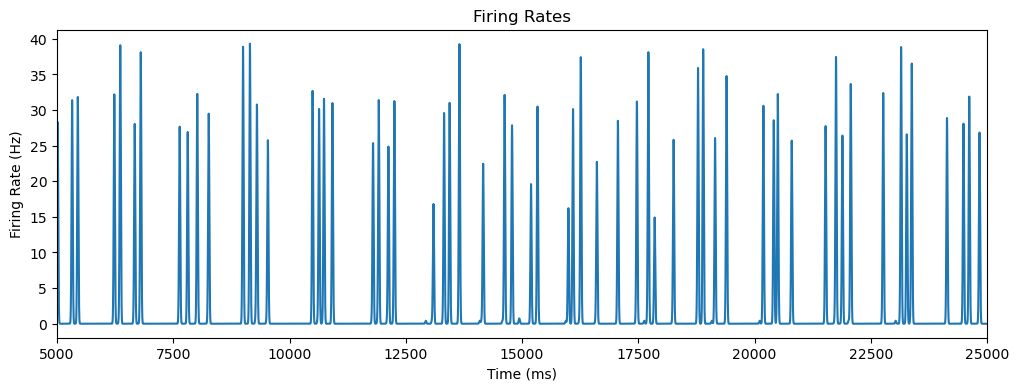

In [26]:
print("len of tissue signal", len(tissue_response_rate))
print("type of tissue signal", type(tissue_response_rate))
firing_rates_plot(time_points, tissue_response_rate, crop_pms) 

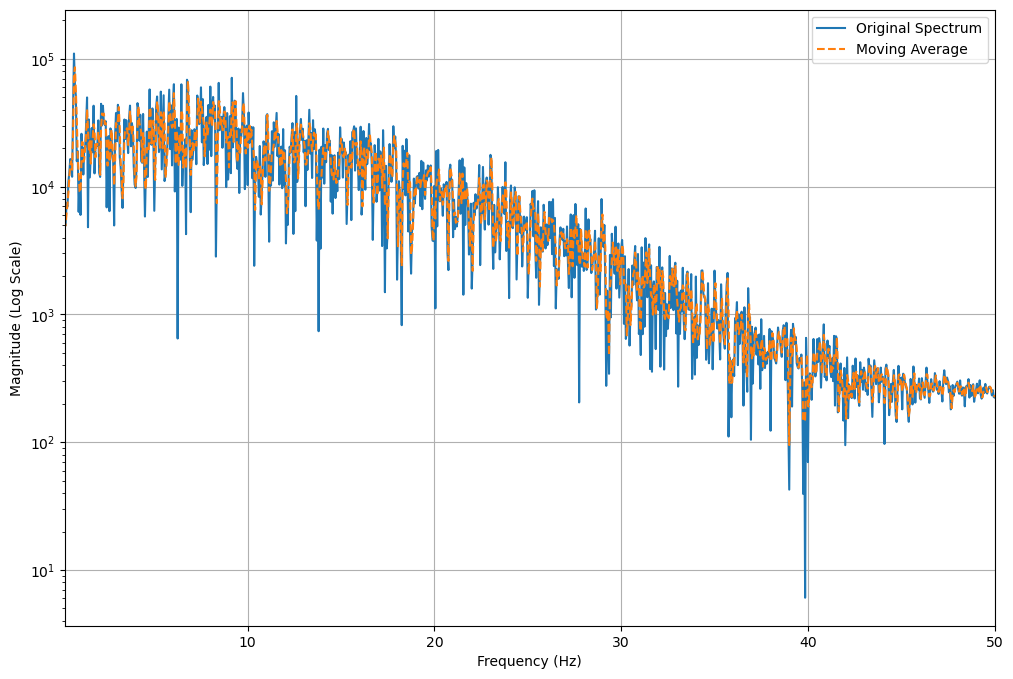

max of fft at 0.7000070000700007


In [27]:
full_spectrum_preview=True
if full_spectrum_preview:
    lower_detectable_freq_Hz=analysis_pms["lower_detectable_frequency_Hz"]
    max_analysis_freq_Hz=analysis_pms["max_nyquist_Hz"]
    max_freq_plot_Hz = 50 #Hz 
    assert(max_freq_plot_Hz <= max_analysis_freq_Hz)
    averaging_freq_window_size_Hz = 2 #Hz
    compute_and_plot_spectrum_with_moving_average(tissue_response_rate,\
       analysis_pms, averaging_freq_window_size_Hz, max_freq_plot_Hz)
    #compute_and_plot_spectrum_with_moving_average(combined_firing_rate, sampling_rate_Hz, averaging_freq_window_size_Hz, max_freq_plot_Hz)


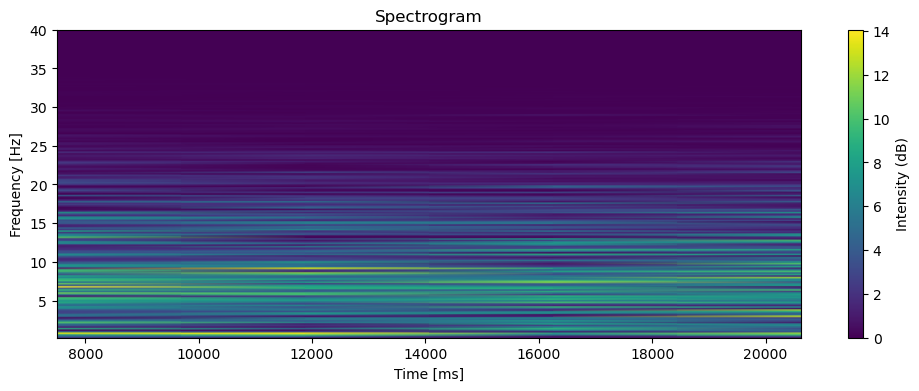

In [28]:
max_plot_freq_Hz=40
#Spectrogram plot
plot_spectrogram(time_points[0],\
                 tissue_response_rate,\
                 analysis_pms, max_plot_freq_Hz)

#Spectrogram plot
#plot_spectrogram(time_points[0], combined_firing_rate, analysis_pms)